# Basic usage for `ldpc_post_selection` package

In [1]:
import stim
import numpy as np

%load_ext autoreload
%autoreload 2

## Global strategy

In [2]:
# Example circuit
from ldpc_post_selection.stim_tools import remove_detectors_from_circuit

circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=9,
    distance=9,
    after_clifford_depolarization=0.005,
    before_measure_flip_probability=0.005,
    after_reset_flip_probability=0.005,
)

# Use only Z-type detectors for evaluating confidence

detector_coords = circuit.get_detector_coordinates()
det_ids_to_remove = []  # X-type detectors
for det_id, (x, y, z) in detector_coords.items():
    if (round(x) + round(y)) % 4 == 2:
        det_ids_to_remove.append(det_id)
circuit = remove_detectors_from_circuit(circuit, det_ids_to_remove)

In [3]:
# Define the decoder
from ldpc_post_selection.decoder import SoftOutputsBpLsdDecoder

bplsd = SoftOutputsBpLsdDecoder(
    circuit=circuit,
    max_iter=30,
    bp_method="minimum_sum",
    lsd_method="LSD_0",
    lsd_order=0,
    ms_scaling_factor=1.0,
)

In [4]:
# Decode a single sample with soft outputs

sampler = circuit.compile_detector_sampler(seed=42)
det, obs = sampler.sample(shots=1, separate_observables=True)

correction, correction_bp, converge, soft_outputs = bplsd.decode(det[0])
obs_correction = correction @ bplsd.obs_matrix.T % 2
success = np.all(obs[0] == obs_correction)


from pprint import pprint

print("Correction:", correction)
print("Correction from BP (valid only when BP converges):", correction_bp)
print("Whether BP converges:", converge)
print("Decoding success:", success)
print()
print("Soft outputs:")
pprint(soft_outputs)

Correction: [False False False ... False False False]
Correction from BP (valid only when BP converges): [False False False ... False False False]
Whether BP converges: True
Decoding success: True

Soft outputs:
{'cluster_llrs': array([1.00665782e+04, 4.36430835e+00, 5.92425580e+00, 4.53799718e+00,
       4.17360043e+00, 5.05741505e+00, 4.17360043e+00, 4.53799718e+00,
       4.17360043e+00, 4.17360043e+00, 5.23111577e+00]),
 'cluster_sizes': array([1935,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1]),
 'clusters': array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
 'detector_density': np.float64(0.05),
 'pred_llr': 46.34749104768056}


**Soft outputs:**

- `'cluster_sizes'`: Cluster sizes (first element: outside clusters)
- `'cluster_llrs'`: LLR sums within each cluster (first element: outside clusters)
- `'clusters'`: Cluster assignment for each error mechanism (0: outside clusters, `i>0`: `i`-th cluster)
- `'detector_density'`: Number of violated detectors divided by the total number of detectors
- `'pred_llr'`: LLR weight of the correction

*Note:* The `norm_frac_orders` parameter of `decode()` is optional and exists just for convenience. Alternatively, the size/LLR norm fraction can be manually calculated from `'cluster_sizes'` and `'cluster_llrs'`.

In [8]:
# Compute cluster size/LLR norm fractions

from ldpc_post_selection.cluster_tools import compute_norm_fraction

size_norm_frac = compute_norm_fraction(soft_outputs["cluster_sizes"], 2)
llr_norm_frac = compute_norm_fraction(soft_outputs["cluster_llrs"], 2)
print("Cluster size 2-norm fraction =", size_norm_frac)
print("Cluster LLR 2-norm fraction =", llr_norm_frac)

size_norm_frac = compute_norm_fraction(soft_outputs["cluster_sizes"], np.inf)
llr_norm_frac = compute_norm_fraction(soft_outputs["cluster_llrs"], np.inf)
print("Cluster size infinity-norm fraction =", size_norm_frac)
print("Cluster LLR infinity-norm fraction =", llr_norm_frac)

Cluster size 2-norm fraction = 0.0016258496967446682
Cluster LLR 2-norm fraction = 0.0014598231241090044
Cluster size infinity-norm fraction = 0.0005141388174807198
Cluster LLR infinity-norm fraction = 0.0005858102776987654


In [9]:
# Post-selection simulation with cluster LLR 2-norm fraction

from tqdm import tqdm

shots = 100000

sampler = circuit.compile_detector_sampler(seed=42)
det, obs = sampler.sample(shots=shots, separate_observables=True)

fails = []
norm_fracs = []

for i_sample in tqdm(list(range(shots))):
    correction, _, _, soft_outputs = bplsd.decode(det[i_sample])
    obs_correction = correction @ bplsd.obs_matrix.T % 2
    fail = np.any(obs[i_sample] != obs_correction)
    norm_frac = compute_norm_fraction(soft_outputs["cluster_llrs"], 2)
    fails.append(fail)
    norm_fracs.append(norm_frac)

100%|██████████| 100000/100000 [00:53<00:00, 1856.17it/s]


In [10]:
# Calculate failure rates for different cutoffs

from statsmodels.stats.proportion import proportion_confint

fails_array = np.array(fails)
norm_fracs_array = np.array(norm_fracs)
cutoffs = np.logspace(np.log10(min(norm_fracs)), np.log10(max(norm_fracs)), 100)

mask = norm_fracs_array[np.newaxis, :] <= cutoffs[:, np.newaxis]
num_selected = mask.sum(axis=1)
num_failures = (mask * fails_array[np.newaxis, :]).sum(axis=1)

failure_rates = num_failures / num_selected
abort_rates = 1 - num_selected / shots

# Calculate 95% confidence intervals using Wilson score interval
confidence_level = 0.95

# Failure rate confidence intervals
failure_rate_lower, failure_rate_upper = proportion_confint(
    num_failures, num_selected, alpha=1 - confidence_level, method="wilson"
)

# Abort rate confidence intervals (based on selection rate)
# Calculate CI for selection rate, then convert to abort rate
selection_rate_lower, selection_rate_upper = proportion_confint(
    num_selected, shots, alpha=1 - confidence_level, method="wilson"
)

# Abort rate is 1 - selection rate, so we flip the bounds
abort_rate_lower = 1 - selection_rate_upper
abort_rate_upper = 1 - selection_rate_lower

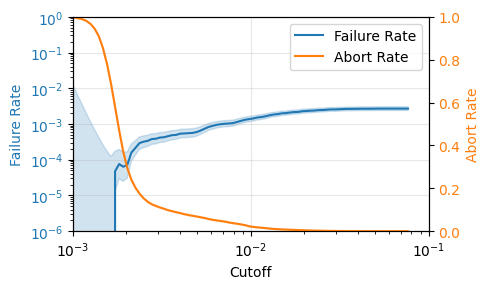

In [11]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot failure rate on left y-axis
color1 = "tab:blue"
ax1.set_xlabel("Cutoff")
ax1.set_ylabel("Failure Rate", color=color1)
ax1.plot(cutoffs, failure_rates, color=color1, label="Failure Rate")
ax1.fill_between(
    cutoffs, failure_rate_lower, failure_rate_upper, color=color1, alpha=0.2
)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create second y-axis for abort rate
ax2 = ax1.twinx()
color2 = "tab:orange"
ax2.set_ylabel("Abort Rate", color=color2)
ax2.plot(cutoffs, abort_rates, color=color2, label="Abort Rate")
ax2.fill_between(cutoffs, abort_rate_lower, abort_rate_upper, color=color2, alpha=0.2)
ax2.tick_params(axis="y", labelcolor=color2)

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.set_xlim(1e-3, 1e-1)
ax1.set_ylim(1e-6, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Real-time strategy

In [13]:
# Example circuit
from ldpc_post_selection.stim_tools import remove_detectors_from_circuit

circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=9,
    distance=9,
    after_clifford_depolarization=0.005,
    before_measure_flip_probability=0.005,
    after_reset_flip_probability=0.005,
)

# Use only Z-type detectors for evaluating confidence

detector_coords = circuit.get_detector_coordinates()
det_ids_to_remove = []  # X-type detectors
for det_id, (x, y, z) in detector_coords.items():
    if (round(x) + round(y)) % 4 == 2:
        det_ids_to_remove.append(det_id)
circuit = remove_detectors_from_circuit(circuit, det_ids_to_remove)

In [14]:
# Define the decoder

bplsd = SoftOutputsBpLsdDecoder(
    circuit=circuit,
    max_iter=30,
    bp_method="minimum_sum",
    lsd_method="LSD_0",
    lsd_order=0,
    ms_scaling_factor=1.0,
    detector_time_coords=-1,
)

*Note:* The `detector_time_coords` parameter (default `-1`) determines the time coordinates of detectors, which is necessary for sliding-window decoding (SWD). If an integer `i` is given, the `i`-th coordinate of each detector annotated in the stim circuit is treated as its time coordinate. If a sequence of integers is given, it directly specifies the time coordinates.

In [15]:
# Decode a single sample via sliding-window method with soft outputs for each window

sampler = circuit.compile_detector_sampler(seed=42)
det, obs = sampler.sample(shots=1, separate_observables=True)

correction, soft_outputs = bplsd.decode_sliding_window(
    det[0], window_size=5, commit_size=1
)
obs_correction = correction @ bplsd.obs_matrix.T % 2
success = np.all(obs[0] == obs_correction)

from pprint import pprint

print("Correction:", correction)
print("Decoding success:", success)
print()
print("Soft outputs:")
pprint(soft_outputs)

Correction: [False False False ... False False False]
Decoding success: True

Soft outputs:
{'all_clusters': [array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,))],
 'committed_clusters': [array([False, False, False, ..., False, False, False], shape=(1945,)),
                        array([False, False, False, ..., False, False, False], shape=(1945,)),
                        array([False, False, False, ..., False, False, False], shape=(1945,)),
                        array([False, False, False, ..., False, False, False], shape=(1945,)),
                        array([False, False, False, ..., False, False, False], shape=(1945,)),
                        array([False, Fals

**Soft outputs:**

All the values of the dictionary are lists of arrays, where each element is obtained from decoding a window. Namely, the length of each list is equal to the number of windows.

- `all_clusters[i]` (integer array): Cluster assignment obtained from decoding the `i`-th window.
- `committed_clusters[i]` (boolean array): Specifies whether each error mechanism belongs to a cluster AND is committed from the `i`-th window.
- `committed_faults[i]` (boolean array): Specifies whether each error mechanism is committed from the `i`-th window. (This is determined by the circuit and the parameters of SWD, independent of the sample, and thus it is strictly not a soft output of decoding. However, we include this in the dictionary for convenience.)

In [ ]:
# TODO: Create a function for calculating committed norm fraction